Data Preprocessing

In [20]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer

# Load data
df = pd.read_csv('MarketPricePrediction.csv')

# Handle missing values
imputer = SimpleImputer(strategy='mean')
df['quantity'] = imputer.fit_transform(df[['quantity']])
df['priceMin'] = imputer.fit_transform(df[['priceMin']])
df['priceMax'] = imputer.fit_transform(df[['priceMax']])
df['priceMod'] = imputer.fit_transform(df[['priceMod']])

# Encode categorical variables
le_market = LabelEncoder()
df['market'] = le_market.fit_transform(df['market'])
le_state = LabelEncoder()
df['state'] = le_state.fit_transform(df['state'])
le_city = LabelEncoder()
df['city'] = le_city.fit_transform(df['city'])

# Extract date components
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
print(df.head())



   market  month  year  quantity  priceMin  priceMax  priceMod  state  city  \
0       0      1  2005    2350.0     404.0     493.0     446.0     16     0   
1       0      1  2006     900.0     487.0     638.0     563.0     16     0   
2       0      1  2010     790.0    1283.0    1592.0    1460.0     16     0   
3       0      1  2011     245.0    3067.0    3750.0    3433.0     16     0   
4       0      1  2012    1035.0     523.0     686.0     605.0     16     0   

        date  
0 2005-01-01  
1 2006-01-01  
2 2010-01-01  
3 2011-01-01  
4 2012-01-01  


Exploratory Data Analysis (EDA)

C:\Users\HIMA\AppData\Local\Temp\ipykernel_11564\761986568.py:18: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()  # Adjust the padding of the plot


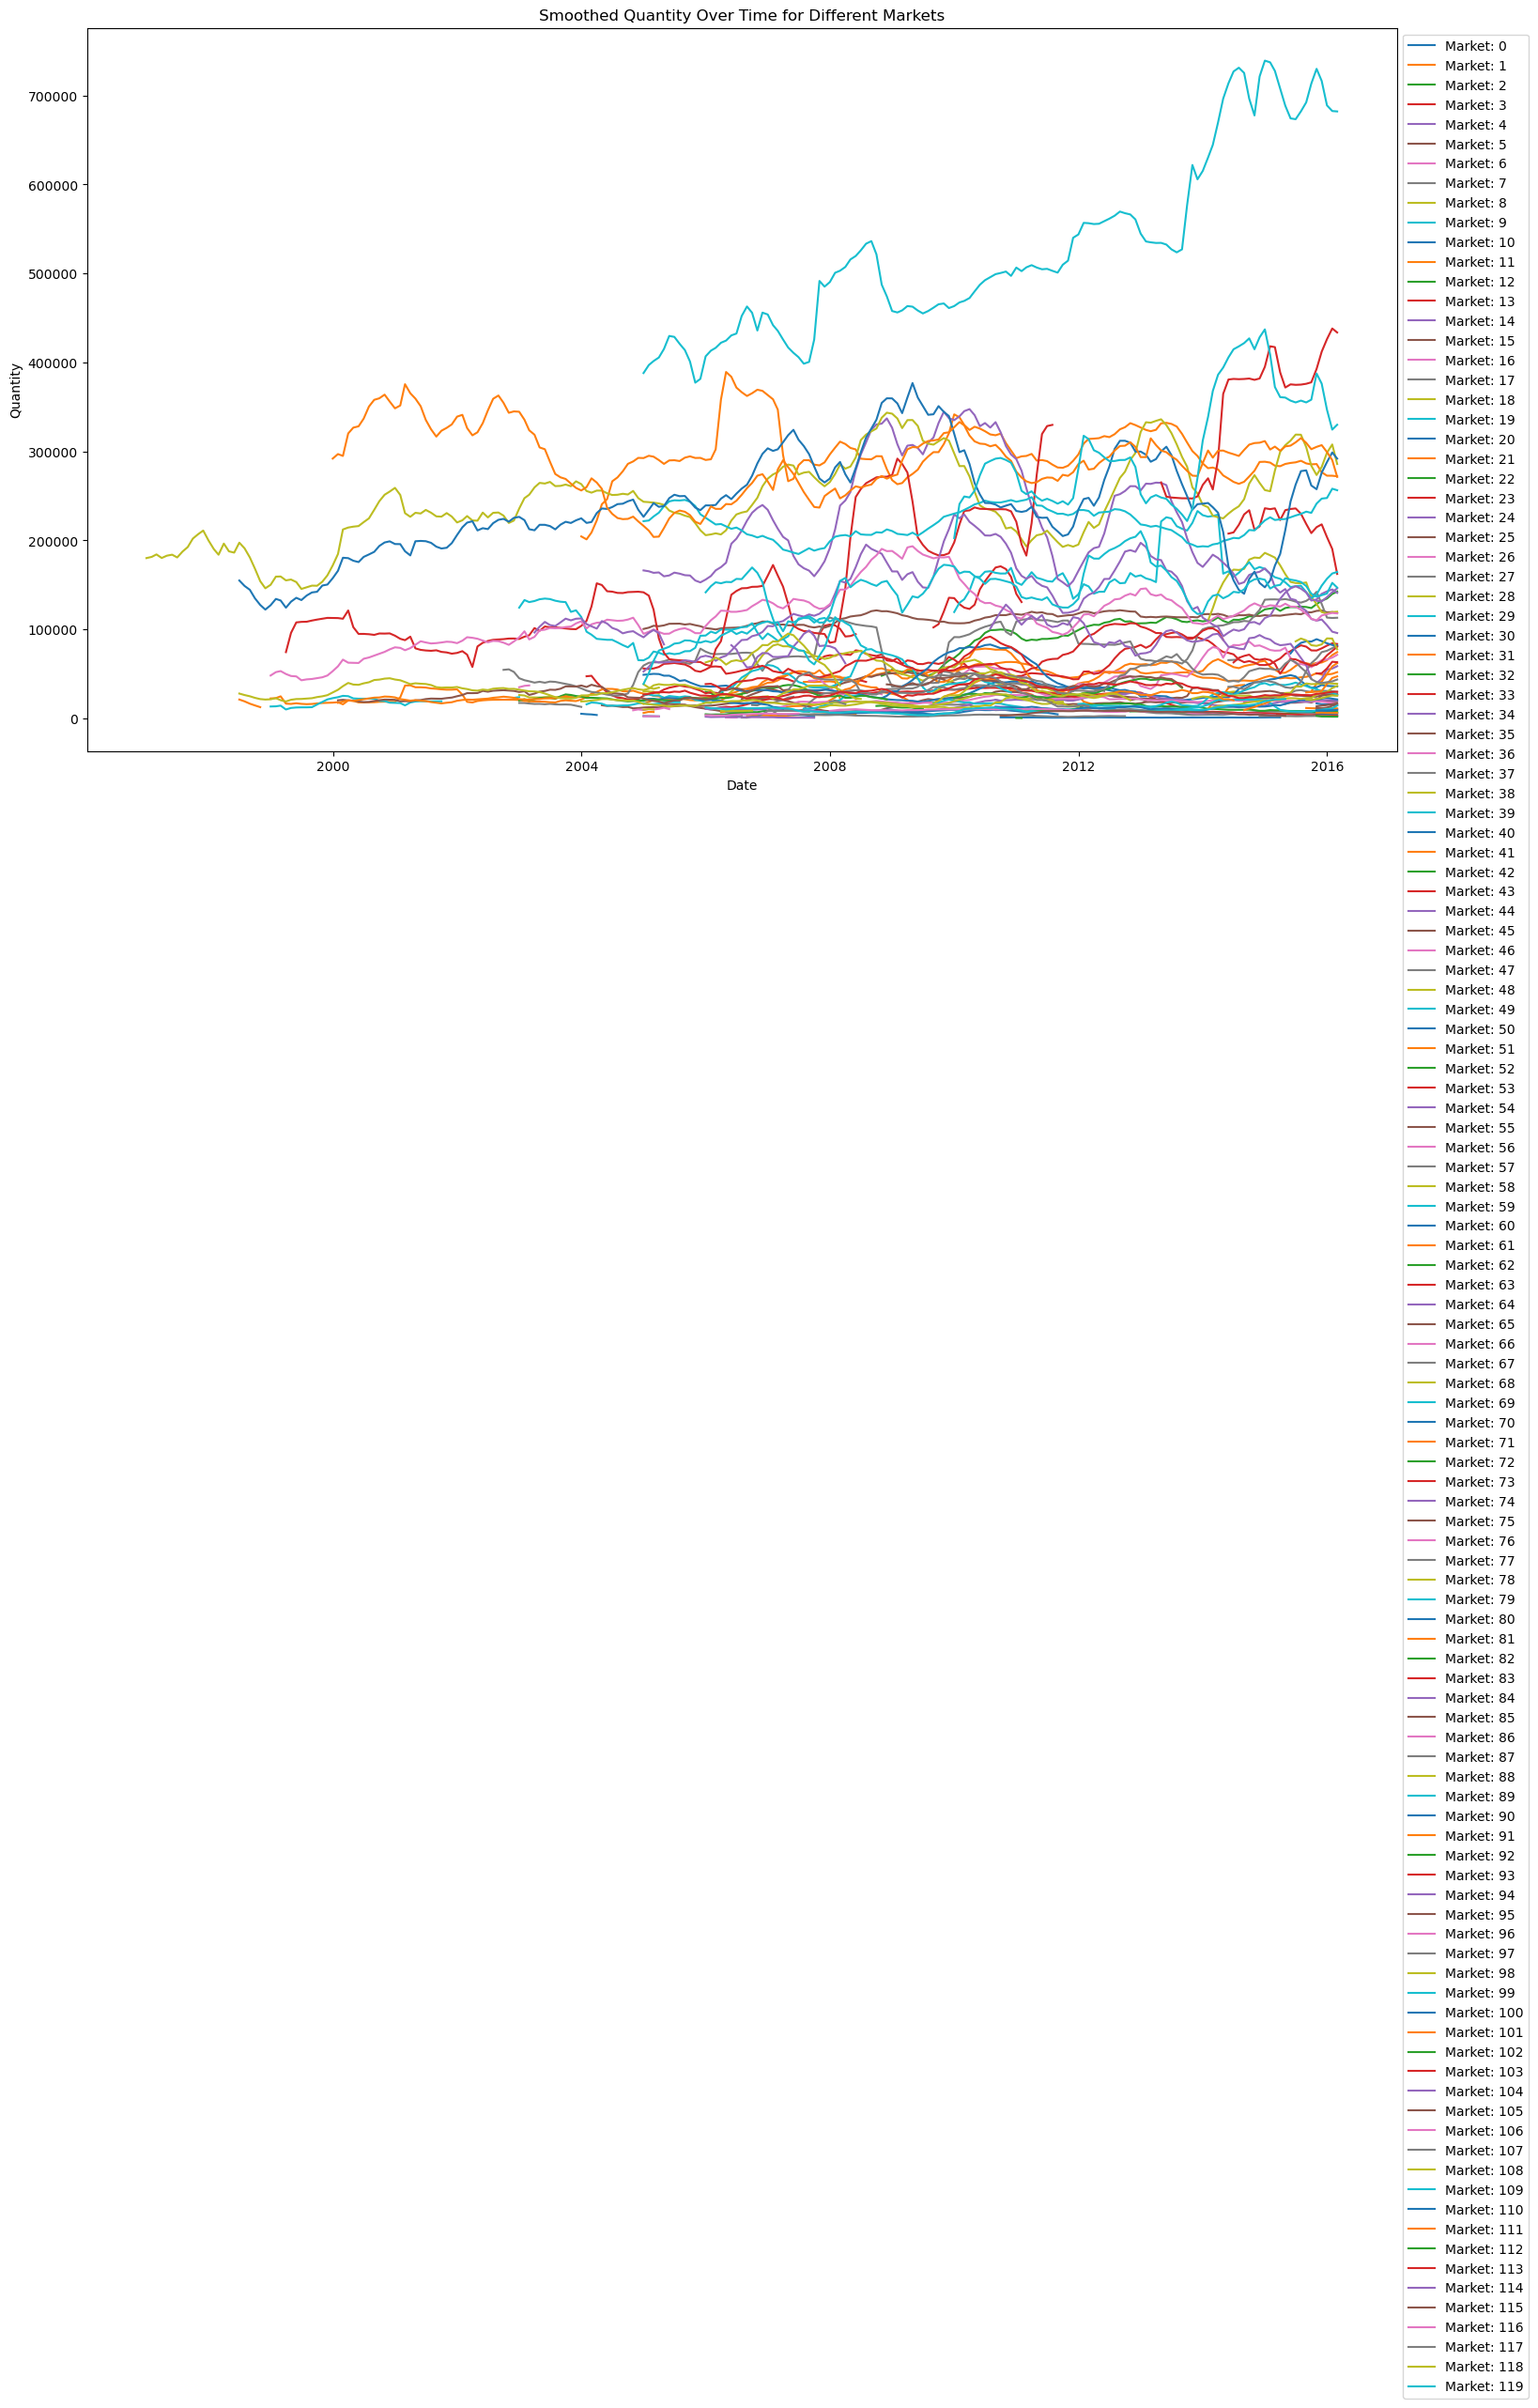

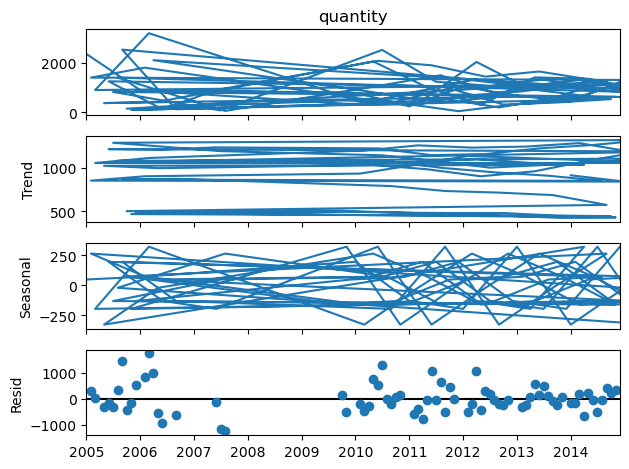

C:\Users\HIMA\AppData\Local\Temp\ipykernel_11564\761986568.py:34: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), annot=True, cmap='coolwarm')


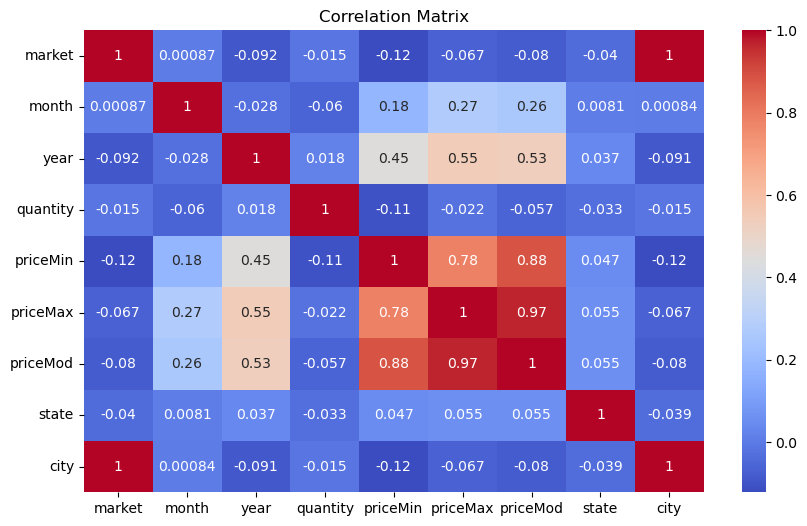

In [22]:
def smooth_data(series, window=12):
    return series.rolling(window=window).mean()

# Plot data for individual markets with smoothing
unique_markets = df['market'].unique()

plt.figure(figsize=(18, 10))  # Make the graph bigger

for market in unique_markets:
    market_df = df[df['market'] == market].set_index('date').resample('M').mean()  # Resample to monthly frequency
    smoothed_quantity = smooth_data(market_df['quantity'])
    plt.plot(smoothed_quantity, label=f'Market: {market}')

plt.title('Smoothed Quantity Over Time for Different Markets')
plt.xlabel('Date')
plt.ylabel('Quantity')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))  # Ensure the labels are within the graph frame
plt.tight_layout()  # Adjust the padding of the plot
plt.show()

# Decompose time series
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns


selected_market = unique_markets[0]
selected_market_df = df[df['market'] == selected_market].set_index('date')
result = seasonal_decompose(selected_market_df['quantity'], model='additive', period=12)
result.plot()
plt.show()

# Correlation matrix
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


Feature Engineering

In [16]:
# Create lagged features
df['quantity_lag1'] = df['quantity'].shift(1)
df['quantity_lag2'] = df['quantity'].shift(2)

# Create rolling statistics
df['quantity_roll_mean'] = df['quantity'].rolling(window=3).mean()
df['quantity_roll_std'] = df['quantity'].rolling(window=3).std()

# Create seasonal indicators
df = pd.get_dummies(df, columns=['month'], drop_first=True)

# Drop rows with NaN values created by shifting
df = df.dropna()
print(df.head())


   market  year  quantity  priceMin  priceMax  priceMod  state  city  \
2       0  2010     790.0    1283.0    1592.0    1460.0     16     0   
3       0  2011     245.0    3067.0    3750.0    3433.0     16     0   
4       0  2012    1035.0     523.0     686.0     605.0     16     0   
5       0  2013     675.0    1327.0    1900.0    1605.0     16     0   
6       0  2014     440.0    1025.0    1481.0    1256.0     16     0   

        date  quantity_lag1  ...  month_3  month_4  month_5  month_6  month_7  \
2 2010-01-01          900.0  ...        0        0        0        0        0   
3 2011-01-01          790.0  ...        0        0        0        0        0   
4 2012-01-01          245.0  ...        0        0        0        0        0   
5 2013-01-01         1035.0  ...        0        0        0        0        0   
6 2014-01-01          675.0  ...        0        0        0        0        0   

   month_8  month_9  month_10  month_11  month_12  
2        0        0         

Model Selection and Training

<font size="4">ARIMA/SARIMA Model</font>

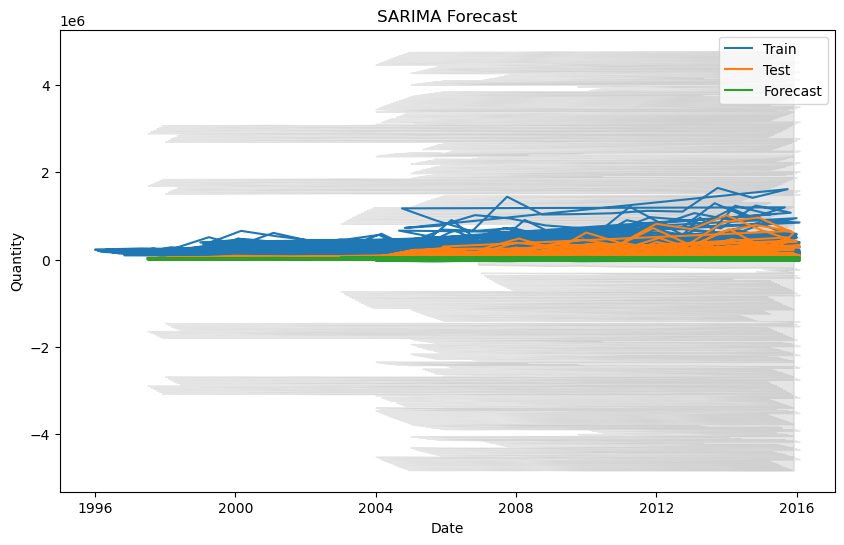

In [23]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Split data into train and test sets
train_size = int(len(df) * 0.8)
train, test = df[:train_size], df[train_size:]

# Train SARIMA model
sarima_model = SARIMAX(train['quantity'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
sarima_result = sarima_model.fit()

# Forecast
forecast = sarima_result.get_forecast(steps=len(test))
forecast_ci = forecast.conf_int()

# Plot forecast
plt.figure(figsize=(10, 6))
plt.plot(train['date'], train['quantity'], label='Train')
plt.plot(test['date'], test['quantity'], label='Test')
plt.plot(test['date'], forecast.predicted_mean, label='Forecast')
plt.fill_between(test['date'], forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='gray', alpha=0.2)
plt.title('SARIMA Forecast')
plt.xlabel('Date')
plt.ylabel('Quantity')
plt.legend()
plt.show()


<font size="4">LSTM Model</font>

In [24]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler

# Prepare data for LSTM
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[['quantity']])

# Create sequences
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i + seq_length]
        y = data[i + seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 12
X, y = create_sequences(scaled_data, seq_length)

# Split data into train and test sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Build LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(seq_length, 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, batch_size=1, epochs=5)

plt.show()


c:\Users\HIMA\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
8172/8172 ━━━━━━━━━━━━━━━━━━━━ 53s 6ms/step - loss: 0.0024
Epoch 2/5
8172/8172 ━━━━━━━━━━━━━━━━━━━━ 45s 5ms/step - loss: 0.0018
Epoch 3/5
8172/8172 ━━━━━━━━━━━━━━━━━━━━ 50s 6ms/step - loss: 0.0019
Epoch 4/5
8172/8172 ━━━━━━━━━━━━━━━━━━━━ 48s 6ms/step - loss: 0.0018
Epoch 5/5
8172/8172 ━━━━━━━━━━━━━━━━━━━━ 45s 6ms/step - loss: 0.0016


64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


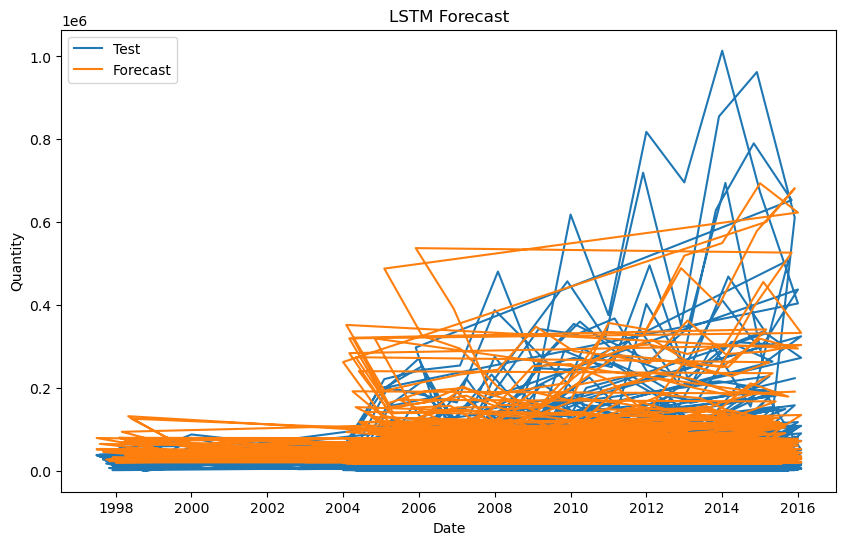

In [26]:
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

# Plot forecast
plt.figure(figsize=(10, 6))
plt.plot(df['date'][-len(y_test):], scaler.inverse_transform(y_test.reshape(-1, 1)), label='Test')
plt.plot(df['date'][-len(predictions):], predictions, label='Forecast')
plt.title('LSTM Forecast')
plt.xlabel('Date')
plt.ylabel('Quantity')
plt.legend()
plt.show()


Model Evaluation

In [27]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Evaluate SARIMA
sarima_pred = forecast.predicted_mean
mae_sarima = mean_absolute_error(test['quantity'], sarima_pred)
mse_sarima = mean_squared_error(test['quantity'], sarima_pred)
rmse_sarima = np.sqrt(mse_sarima)

# Evaluate LSTM
mae_lstm = mean_absolute_error(scaler.inverse_transform(y_test.reshape(-1, 1)), predictions)
mse_lstm = mean_squared_error(scaler.inverse_transform(y_test.reshape(-1, 1)), predictions)
rmse_lstm = np.sqrt(mse_lstm)

print(f'SARIMA - MAE: {mae_sarima}, MSE: {mse_sarima}, RMSE: {rmse_sarima}')
print(f'LSTM - MAE: {mae_lstm}, MSE: {mse_lstm}, RMSE: {rmse_lstm}')


SARIMA - MAE: 52889.471534011725, MSE: 10134598865.415205, RMSE: 100670.74483391491
LSTM - MAE: 30677.19255632801, MSE: 2955460539.6785936, RMSE: 54364.147557729564
